
### Chicago Food Inspections - Project using PySpark NLP

This notebook demonstrates NLP with PySpark

**Dataset:**
https://www.kaggle.com/chicago/chi-restaurant-inspections


<image src="https://spark.apache.org/docs/latest/img/ml-Pipeline.png" width="40%"/>

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Row
from pyspark.sql.functions import UserDefinedFunction
from pyspark.sql.types import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer, StringIndexer, CountVectorizer, IDF
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

In [3]:
spark = SparkSession.builder.appName('ChicagoFoodInspectionNLP').getOrCreate()

conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '4g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','4g')])

spark.sparkContext.getConf().getAll()

24/01/28 17:31:44 WARN Utils: Your hostname, Sais-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 10.150.141.237 instead (on interface en0)
24/01/28 17:31:44 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/28 17:31:44 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


[('spark.driver.port', '59847'),
 ('spark.app.id', 'local-1706484705376'),
 ('spark.driver.memory', '4g'),
 ('spark.executor.memory', '4g'),
 ('spark.executor.id', 'driver'),
 ('spark.app.startTime', '1706484704845'),
 ('spark.executor.cores', '4'),
 ('spark.cores.max', '4'),
 ('spark.driver.extraJavaOptions',
  '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.cale

## Data Exploration

In [5]:
df = spark.read.csv("/Users/saiomkarkandukuri/Desktop/Academics/Academics-001/big-data-platforms/week6/chicago-food-inspections/food-inspections.csv", inferSchema=True, header=True)

In [6]:
df.printSchema()

root
 |-- Inspection ID: integer (nullable = true)
 |-- DBA Name: string (nullable = true)
 |-- AKA Name: string (nullable = true)
 |-- License #: integer (nullable = true)
 |-- Facility Type: string (nullable = true)
 |-- Risk: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zip: integer (nullable = true)
 |-- Inspection Date: timestamp (nullable = true)
 |-- Inspection Type: string (nullable = true)
 |-- Results: string (nullable = true)
 |-- Violations: string (nullable = true)
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Location: string (nullable = true)



In [7]:
df = df.dropna()

In [8]:
df2 = df.groupby("Results").count()
df2.show()

+------------------+-----+
|           Results|count|
+------------------+-----+
|         Not Ready|   31|
|              Fail|30889|
|          No Entry|  403|
|Pass w/ Conditions|18849|
|   Out of Business|   23|
|              Pass|78399|
+------------------+-----+



<Axes: ylabel='count'>

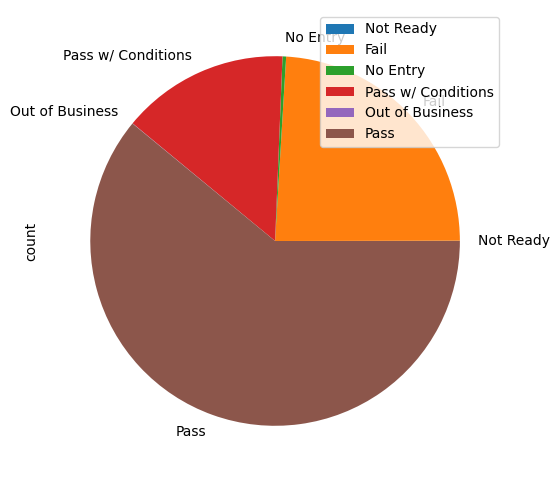

In [9]:
resultsdf = df2.toPandas()
resultsdf.plot.pie(y='count', labels = resultsdf['Results'], figsize=(6, 6))

## Feature Engineering

### Method 1 - converting categorical variables to numeric using the UserDefinedFunction()



In [10]:
def labelForResults(s):
    if s == 'Fail':
        return 0.0
    elif s == 'Pass w/ Conditions' or s == 'Pass':
        return 1.0
    else:
        return -1.0
    
label = UserDefinedFunction(labelForResults, DoubleType())
labeledData = df.select(df.Violations,label(df.Results).alias('label')).where('label >= 0')
labeledData.show(10)

+--------------------+-----+
|          Violations|label|
+--------------------+-----+
|3. MANAGEMENT, FO...|  1.0|
|3. MANAGEMENT, FO...|  1.0|
|3. MANAGEMENT, FO...|  1.0|
|3. MANAGEMENT, FO...|  1.0|
|3. MANAGEMENT, FO...|  1.0|
|3. MANAGEMENT, FO...|  1.0|
|3. MANAGEMENT, FO...|  1.0|
|2. CITY OF CHICAG...|  0.0|
|3. MANAGEMENT, FO...|  1.0|
|3. MANAGEMENT, FO...|  1.0|
+--------------------+-----+
only showing top 10 rows



### Method 2 - convert categorical variable to numeric using StringIndexer()



In [11]:
indexer = StringIndexer(inputCol="Results", outputCol="label")
indexedData = indexer.fit(df).transform(df)
indexedData = indexedData.select("Violations", "label")
indexedData.show(10)

+--------------------+-----+
|          Violations|label|
+--------------------+-----+
|3. MANAGEMENT, FO...|  2.0|
|3. MANAGEMENT, FO...|  2.0|
|3. MANAGEMENT, FO...|  2.0|
|3. MANAGEMENT, FO...|  2.0|
|3. MANAGEMENT, FO...|  2.0|
|3. MANAGEMENT, FO...|  2.0|
|3. MANAGEMENT, FO...|  2.0|
|2. CITY OF CHICAG...|  1.0|
|3. MANAGEMENT, FO...|  2.0|
|3. MANAGEMENT, FO...|  2.0|
+--------------------+-----+
only showing top 10 rows



## Classification 

Let's predict the Inspection result as label based on Violations as features. To do this we will tokenize the violations and use two different methods for performing the classification - HashingTF and Count Vectorizer

In [12]:
#Tokenizing the data into words
tokenizer = Tokenizer(inputCol="Violations", outputCol="words")

### Method 1 : HashingTF

*HashingTF* utilizes the hashing trick. A raw feature is mapped into an index (term) by applying a hash function. The hash function used here is [MurmurHash3](https://en.wikipedia.org/wiki/MurmurHash). Then term frequencies are calculated based on the mapped indices. This approach avoids the need to compute a global term-to-index map, which can be expensive for a large corpus, but it suffers from potential hash collisions, where different raw features may become the same term after hashing.

In [13]:
#Mapping a sequence of terms to their term frequencies using the hashing trick. 
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")

#A Pipeline chains multiple Transformers and Estimators together to specify an ML workflow
pipeline = Pipeline(stages=[indexer,tokenizer, hashingTF])
encodedData = pipeline.fit(df).transform(df)

### Split data

In [14]:
train_df, test_df = encodedData.randomSplit([.8,.2],seed=1234)
train_df.show(10, truncate = True)

+-------------+--------------------+--------------------+---------+--------------------+---------------+--------------------+-------+-----+-----+-------------------+---------------+------------------+--------------------+------------------+------------------+--------------------+-----+--------------------+--------------------+
|Inspection ID|            DBA Name|            AKA Name|License #|       Facility Type|           Risk|             Address|   City|State|  Zip|    Inspection Date|Inspection Type|           Results|          Violations|          Latitude|         Longitude|            Location|label|               words|            features|
+-------------+--------------------+--------------------+---------+--------------------+---------------+--------------------+-------+-----+-----+-------------------+---------------+------------------+--------------------+------------------+------------------+--------------------+-----+--------------------+--------------------+
|      167225

### Build Model

In [16]:
#Logistic Regression Model
lr = LogisticRegression(maxIter=10, regParam=0.01)

lrm = lr.fit(train_df)


Java HotSpot(TM) 64-Bit Server VM warning: CodeCache is full. Compiler has been disabled.
Java HotSpot(TM) 64-Bit Server VM warning: Try increasing the code cache size using -XX:ReservedCodeCacheSize=


CodeCache: size=131072Kb used=35574Kb max_used=35579Kb free=95497Kb
 bounds [0x00000001069e0000, 0x0000000108d20000, 0x000000010e9e0000]
 total_blobs=13401 nmethods=12377 adapters=934
 compilation: disabled (not enough contiguous free space left)


24/01/28 17:48:26 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


### Predictions

In [17]:
predictions = lrm.transform(test_df)
predictions.show(1, truncate =False)

24/01/28 17:48:49 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


+-------------+------------+------------+---------+-------------+-------------+----------------+-------+-----+-----+-------------------+---------------+-------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------

### Evaluation Metrics

In [18]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

24/01/28 17:49:23 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


0.9251863475872891


24/01/28 17:49:34 WARN DAGScheduler: Broadcasting large task binary with size 8.5 MiB


0.9235075617699052


## Cross Validation

We now treat the Pipeline as an Estimator, wrapping it in a CrossValidator instance. This will allow us to jointly choose parameters for all Pipeline stages.

In [19]:
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [10, 100, 1000]) \
    .addGrid(lr.regParam, [0.1, 0.01]) \
    .build()

#Configuring an ML pipeline with tree stages: tokenizer, hashingTF, and logisticregression lr
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

crossval = CrossValidator(estimator=pipeline,
                          estimatorParamMaps=paramGrid,
                          evaluator=BinaryClassificationEvaluator(),
                          numFolds=2)  # using 3+ folds in practice is standard



In [20]:
# Run cross-validation
cvModel = crossval.fit(labeledData)



In [21]:
# Make predictions on test documents. cvModel uses the best model found (lrModel)

predictions = cvModel.transform(labeledData)

In [22]:
predictions.show(5)

+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|          Violations|label|               words|            features|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|3. MANAGEMENT, FO...|  1.0|[3., management,,...|(1000,[0,7,11,15,...|[-1.5245885649191...|[0.17878682343627...|       1.0|
|3. MANAGEMENT, FO...|  1.0|[3., management,,...|(1000,[7,33,101,1...|[-2.6266612719424...|[0.06744213250357...|       1.0|
|3. MANAGEMENT, FO...|  1.0|[3., management,,...|(1000,[0,11,16,17...|[-1.3223919178748...|[0.21042061593800...|       1.0|
|3. MANAGEMENT, FO...|  1.0|[3., management,,...|(1000,[0,7,11,16,...|[-1.8075370869464...|[0.14093605458896...|       1.0|
|3. MANAGEMENT, FO...|  1.0|[3., management,,...|(1000,[0,7,11,16,...|[-2.6034748101920...|[0.06891512200793...|       1.0|
+-------

### Evaluation

In [23]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

print(evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"}))
print(evaluator.evaluate(predictions, {evaluator.metricName: "f1"}))

0.9386750119013244


0.9372504497281889


24/01/28 19:02:04 WARN HeartbeatReceiver: Removing executor driver with no recent heartbeats: 331396 ms exceeds timeout 120000 ms
24/01/28 19:02:04 WARN SparkContext: Killing executors is not supported by current scheduler.
24/01/28 19:02:05 WARN Executor: Issue communicating with driver in heartbeater
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.SparkThreadUtils$.awaitResult(SparkThreadUtils.scala:56)
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:310)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:101)
	at org.apache.spark.rpc.RpcEndpointRef.askSync(RpcEndpointRef.scala:85)
	at org.apache.spark.storage.BlockManagerMaster.registerBlockManager(BlockManagerMaster.scala:80)
	at org.apache.spark.storage.BlockManager.reregister(BlockManager.scala:642)
	at org.apache.spark.executor.Executor.reportHeartBeat(Executor.scala:1223)
	at o

### Method 2 : Count Vectorizer - Pending

https://spark.apache.org/docs/latest/ml-features.html#countvectorizer

CountVectorizer and CountVectorizerModel aim to help convert a collection of text documents to vectors of token counts. When an a-priori dictionary is not available, CountVectorizer can be used as an Estimator to extract the vocabulary, and generates a CountVectorizerModel. The model produces sparse representations for the documents over the vocabulary, which can then be passed to other algorithms like LDA.

In [ ]:

countVectorizer = CountVectorizer(inputCol=tokenizer.getOutputCol(), outputCol="features")
pipeline = Pipeline(stages=[indexer, tokenizer, countVectorizer])
encodedData = pipeline.fit(df).transform(df)